In [2]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 31.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import io
from IPython.display import display
from ipywidgets import FileUpload

In [29]:
print("Upload your MEI.v2 data file:")
uploader = FileUpload(accept='.data', multiple=False)
display(uploader)

Upload your MEI.v2 data file:


FileUpload(value={}, accept='.data', description='Upload')

In [30]:
# Cell 3: Define the MEI data parsing function
def parse_mei_data(mei_data_string):
    """
    Parses the MEI.v2 (this is multivariate ENSO index)
    The MEI.v2 data format is: YEAR DJ JF FM MA AM MJ JJ JA AS SO ON ND
    """
    # split into lines
    lines = mei_data_string.strip().split('\n')

    data = []

    # running through each line, which reps a year
    for i, line in enumerate(lines):
        # Skip header and footer lines
        if i == 0 or 'Multivariate ENSO Index' in line or 'Row values' in line:
            continue

        line = line.strip()
        if not line or '-999.00' in line:
            continue

        # Split by whitespace remove empty strings
        values = [v for v in line.split() if v]

        if len(values) < 13:
            continue

        year = int(values[0])

        # get valid bi-montyly values
        bimonthly_values = []
        for v in values[1:13]:
            try:
                val = float(v)
                if val > -999:
                    bimonthly_values.append(val)
                else:
                    break
            except ValueError:
                continue

        # if lacking 12 values
        if len(bimonthly_values) < 12:
            continue

        # Convert to monthly vals
        for month in range(12):
            if month == 0:  # January
                v1, v2 = bimonthly_values[0], bimonthly_values[1]  # for year transition
            elif month == 11:  # December
                v1, v2 = bimonthly_values[11], bimonthly_values[0]
            else:
                v1, v2 = bimonthly_values[month], bimonthly_values[month+1]

            # Calculate monthly value as average of the bimonthly values on either side of it
            monthly_value = (v1 + v2) / 2

            date = pd.Timestamp(year=year, month=month+1, day=15)

            data.append({
                'date': date,
                'year': year,
                'month': month + 1,
                'mei': monthly_value
            })

    df = pd.DataFrame(data)
    df.set_index('date', inplace=True)

    return df

In [31]:
def process_mei_upload():
    if not uploader.value:
        print("remember to upload your file")
        return None

    file_content = next(iter(uploader.value.values()))
    mei_data_string = file_content['content'].decode('utf-8')

    # Parse the data
    mei_df = parse_mei_data(mei_data_string)

    # show the user some basic info
    print(f"Loaded MEI data from {min(mei_df.index):%Y-%m} to {max(mei_df.index):%Y-%m}")
    print(f"Total data points: {len(mei_df)}")

    # preview the data
    print("\nPreview of MEI data:")
    display(mei_df.head())

    # Filter to relevant years (1995-2010)
    mei_subset = mei_df[(mei_df.index >= '1995-01-01') & (mei_df.index <= '2010-12-31')]
    print(f"\nFiltered to 1995-2010: {len(mei_subset)} data points")

    # Calculate 12-month rolling average
    mei_subset['mei_12m_avg'] = mei_subset['mei'].rolling(window=12, center=True).mean()

    return mei_subset

mei_data = process_mei_upload()

Loaded MEI data from 1979-01 to 2024-12
Total data points: 552

Preview of MEI data:


,year,month,mei
date,,,
1979-01-15,1979,1,0.38
1979-02-15,1979,2,0.12
1979-03-15,1979,3,0.08
1979-04-15,1979,4,0.24
1979-05-15,1979,5,0.08



Filtered to 1995-2010: 192 data points


<ipython-input-31-f2e773da870b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mei_subset['mei_12m_avg'] = mei_subset['mei'].rolling(window=12, center=True).mean()


In [40]:
print("Upload your iod data file:")
uploader = FileUpload(accept='.csv', multiple=False)
display(uploader)

Upload your iod data file:


FileUpload(value={}, accept='.csv', description='Upload')

In [44]:
# Process the uploaded IOD file
def process_iod_upload():
    """Process the uploaded IOD data file and return a DataFrame"""
    if not uploader.value:
        print("Please upload an IOD data file first!")
        return None

    # Get file content
    file_content = next(iter(uploader.value.values()))
    iod_data_string = file_content['content'].decode('utf-8')

    # Load the IOD data using pandas
    import io
    iod_df = pd.read_csv(io.StringIO(iod_data_string))

    # Print columns just to check on the format
    print(f"IOD data columns: {iod_df.columns.tolist()}")

    # Find the column with dipole index data
    dipole_col = [col for col in iod_df.columns if 'DMI' in col]
    if not dipole_col:
        print("Warning: Could not find DMI column in IOD data!")
        print("Using second column as dipole data...")
        dipole_col = iod_df.columns[1]
    else:
        dipole_col = dipole_col[0]

    # Convert Date column to datetime object and set as the index
    try:
        # Try different date format, one of these two will work.
        try:
            iod_df['Date'] = pd.to_datetime(iod_df['Date'], format='%Y%m')
        except:
            try:
                iod_df['Date'] = pd.to_datetime(iod_df['Date'])
            except:
                print("Warning: Could not parse dates. Check date format in CSV.")
                iod_df = iod_df.reset_index(drop=True)
    except Exception as e:
        print(f"Error processing dates: {e}")

    # Set date as index, assuming conversion worked.
    if 'Date' in iod_df.columns:
        iod_df.set_index('Date', inplace=True)

    # Handle missing values -- we don't want them to be taken as real data
    iod_df[dipole_col] = iod_df[dipole_col].replace(-9999, np.nan)

    # Calculate 12-month rolling average
    iod_df['iod_12m_avg'] = iod_df[dipole_col].rolling(window=12, center=True).mean()

    # Filter to (1995-2010)
    if isinstance(iod_df.index, pd.DatetimeIndex):
        iod_subset = iod_df.loc['1995':'2010']
    else:
        print("Warning: Index is not datetime. Cannot filter by date range.")
        iod_subset = iod_df

    # Display basic info
    print(f"\nProcessed IOD data:")
    if isinstance(iod_df.index, pd.DatetimeIndex):
        print(f"Date range: {iod_subset.index.min()} to {iod_subset.index.max()}")
    print(f"Total data points: {len(iod_subset)}")
    print(f"NaN values: {iod_subset['iod_12m_avg'].isna().sum()}")

    # preview of the data
    display(iod_subset.head())

    return iod_subset

iod_data = process_iod_upload()

IOD data columns: ['Date', ' DMI HadISST1.1  missing value -9999 https://psl.noaa.gov/data/timeseries/month/']

Processed IOD data:
Date range: 1995-01-01 00:00:00 to 2010-12-01 00:00:00
Total data points: 192
NaN values: 0


,DMI HadISST1.1 missing value -9999 https://psl.noaa.gov/data/timeseries/month/,iod_12m_avg
Date,,
1995-01-01,0.140,0.238167
1995-02-01,0.164,0.177667
1995-03-01,-0.050,0.098083
1995-04-01,-0.221,0.039000
1995-05-01,-0.251,-0.050500


Loading precipitation data...
Data loaded!
Filtering data to 1997-2010...
Processing data for each location...
Sydney (New South Wales): Using coordinates (-33.75, 151.25)
Melbourne (Victoria): Using coordinates (-38.75, 143.75)
Brisbane (Queensland): Using coordinates (-26.25, 153.75)
Renmark (South Australia): Using coordinates (-33.75, 141.25)
Wodonga (Victoria): Using coordinates (-36.25, 146.25)
Wentworth (New South Wales): Using coordinates (-33.75, 141.25)
Corowa (New South Wales): Using coordinates (-36.25, 146.25)
Katanning (Western Australia): Using coordinates (-33.75, 118.75)
Port Lincoln (South Australia): Using coordinates (-33.75, 136.25)
Alice Springs (Northern Territory): Using coordinates (-23.75, 133.75)
Rockhampton (Queensland): Using coordinates (-23.75, 151.25)
Tamworth (New South Wales): Using coordinates (-31.25, 151.25)
Launceston (Tasmania): Using coordinates (-41.25, 146.25)
Gunditjmara Country (Victoria): Using coordinates (-38.75, 141.25)
La Perouse (New So

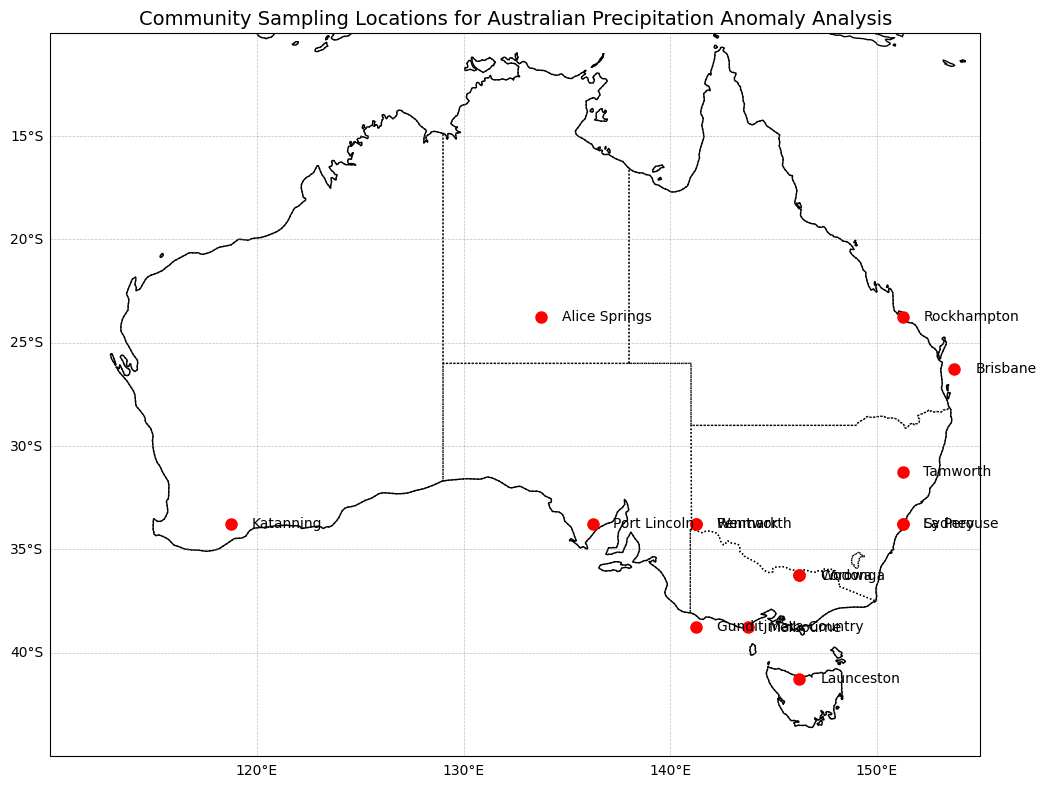

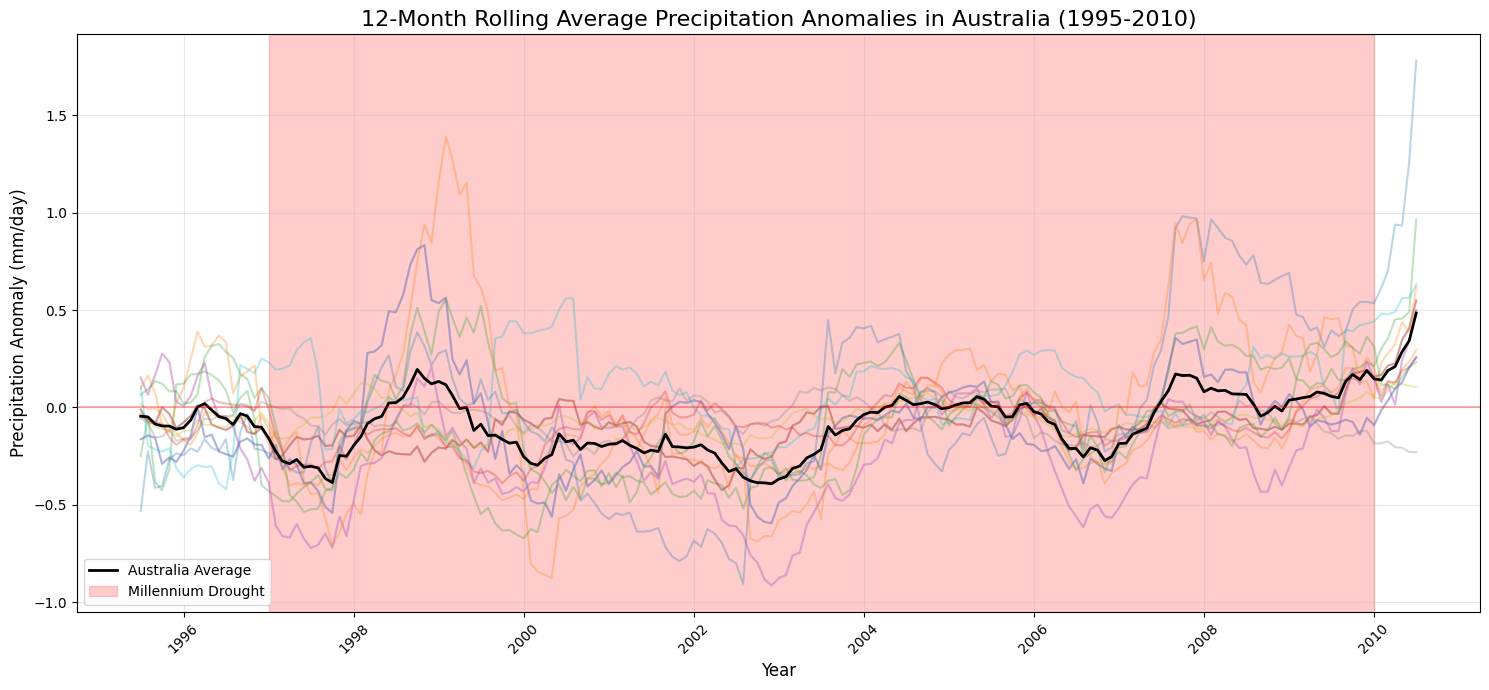


Millennium Drought Analysis (1997-2009) for Australia:
Average Precipitation Anomaly during Drought: -0.1000 mm/day
Minimum Precipitation Anomaly during Drought: -1.1067 mm/day
Maximum Precipitation Anomaly during Drought: 0.9913 mm/day
Standard Deviation during Drought: 0.3521 mm/day
Drought Intensity (Z-score): -0.1077


In [54]:
# Australian Precipitation Anomaly Analysis
# Calculates monthly precipitation anomalies from 1997-2010 for each Australian state

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import requests
import os
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a data directory if it doesn't exist
data_path = './data'
os.makedirs(data_path, exist_ok=True)

# Download precipitation data if not already available
precip_file = os.path.join(data_path, 'precip.mon.anom.nc')
if not os.path.exists(precip_file):
    print("Downloading precipitation anomaly data...")
    url = "https://downloads.psl.noaa.gov/Datasets/prec/precip.mon.anom.nc"
    r = requests.get(url, stream=True)
    with open(precip_file, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Download complete!")

# Load the precipitation data
print("Loading precipitation data...")
prec_data = xr.open_dataset(precip_file)
print("Data loaded!")

# Define coordinates for one point in each Australian state/territory
# Format: [Community name, Latitude, Longitude, State/Territory]
# Updated list with major cities, Murray River farming communities, and indigenous communities
state_points = [
    # Eastern Australia
    ['Sydney', -33.86, 151.21, 'New South Wales'],
    ['Melbourne', -37.81, 144.96, 'Victoria'],
    ['Brisbane', -27.47, 153.03, 'Queensland'],

    # Murray-Darling Basin (severely affected agricultural areas)
    ['Renmark', -34.19, 140.74, 'South Australia'],
    ['Wodonga', -36.12, 146.89, 'Victoria'],
    ['Wentworth', -34.18, 142.16, 'New South Wales'],
    ['Corowa', -35.32, 147.37, 'New South Wales'],

    # Western Agricultural Regions
    ['Katanning', -33.33, 117.88, 'Western Australia'],
    ['Port Lincoln', -34.72, 135.86, 'South Australia'],

    # Central Australia
    ['Alice Springs', -23.70, 133.88, 'Northern Territory'],

    # Other Drought-Affected Communities
    ['Rockhampton', -23.38, 150.51, 'Queensland'],
    ['Tamworth', -31.09, 150.93, 'New South Wales'],
    ['Launceston', -41.43, 147.14, 'Tasmania'],

    # Indigenous Communities
    ['Gunditjmara Country', -37.54, 142.02, 'Victoria'],
    ['La Perouse', -33.90, 151.28, 'New South Wales']
]

# Define the time range for our analysis
start_date = '1995-01-01'
end_date = '2010-12-31'

# Define the reference period for calculating anomalies
# We'll use the data's built-in anomalies which are relative to 1981-2010
# So no need to recalculate, just filter to our time period

# Filter data to our time range
print("Filtering data to 1997-2010...")
filtered_data = prec_data.sel(time=slice(start_date, end_date))

# Create a DataFrame to store results for each state
results = pd.DataFrame()

# Extract time values for plotting
time_values = filtered_data.time.values

# Function to find the nearest grid point to our coordinates
def find_nearest_grid_point(lat, lon, data):
    # Calculate absolute difference between target and all grid points
    abs_lat = np.abs(data.lat.values - lat)
    abs_lon = np.abs(data.lon.values - lon)

    # Find indices of minimum differences
    lat_idx = abs_lat.argmin()
    lon_idx = abs_lon.argmin()

    return data.lat.values[lat_idx], data.lon.values[lon_idx]

# Process each location
print("Processing data for each location...")
for location, lat, lon, state in state_points:
    # Find the nearest grid point
    nearest_lat, nearest_lon = find_nearest_grid_point(lat, lon, filtered_data)

    # Print the coordinates we're using
    print(f"{location} ({state}): Using coordinates ({nearest_lat}, {nearest_lon})")

    # Extract the precipitation anomaly time series for this point
    point_data = filtered_data.sel(lat=nearest_lat, lon=nearest_lon)

    # Store in the results DataFrame
    results[location] = point_data.precip.values

# Set the index to the time values
results.index = pd.to_datetime(time_values)

# Calculate the average anomaly across all states
results['Australia Average'] = results.mean(axis=1)

# Create a visualization map showing the points we're using
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Add the points
for location, lat, lon, state in state_points:
    nearest_lat, nearest_lon = find_nearest_grid_point(lat, lon, filtered_data)
    ax.plot(nearest_lon, nearest_lat, 'ro', markersize=8, transform=ccrs.PlateCarree())
    ax.text(nearest_lon + 1, nearest_lat, location, transform=ccrs.PlateCarree(),
            horizontalalignment='left', verticalalignment='center')

# Set the map extent to focus on Australia
ax.set_extent([110, 155, -45, -10], crs=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.title('Community Sampling Locations for Australian Precipitation Anomaly Analysis', fontsize=14)
plt.savefig('australia_sampling_points.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate 12-month rolling averages to smooth out the data
rolling_results = results.rolling(window=12, center=True).mean()

# Create a time series plot of the smoothed anomalies
plt.figure(figsize=(15, 7))

# Plot individual state lines with low opacity
for state in rolling_results.columns[:-1]:  # All except the Australia Average
    plt.plot(rolling_results.index, rolling_results[state], alpha=0.3, label=state)

# Plot the Australia average with high opacity
plt.plot(rolling_results.index, rolling_results['Australia Average'], 'k-', linewidth=2, label='Australia Average')

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

# Highlight the Millennium Drought period (1997-2009)
plt.axvspan(datetime(1997, 1, 1), datetime(2009, 12, 31),
            alpha=0.2, color='red', label='Millennium Drought')

# Add labels and title
plt.xlabel('Year', fontsize=12)
plt.ylabel('Precipitation Anomaly (mm/day)', fontsize=12)
plt.title('12-Month Rolling Average Precipitation Anomalies in Australia (1995-2010)', fontsize=16)
plt.grid(True, alpha=0.3)

# Improve x-axis formatting
plt.xticks(rotation=45)

# Add legend but only show a few items to avoid cluttering
handles, labels = plt.gca().get_legend_handles_labels()
# Show only the Australia Average and Millennium Drought in the legend
selected_handles = [handles[-2], handles[-1]]  # The last two items
selected_labels = [labels[-2], labels[-1]]
plt.legend(selected_handles, selected_labels, loc='lower left')

plt.tight_layout()
plt.savefig('australia_precipitation_anomalies_smoothed.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate statistics for the Millennium Drought period
drought_period = results.loc['1997-01-01':'2009-12-31']
drought_avg = drought_period['Australia Average'].mean()
drought_min = drought_period['Australia Average'].min()
drought_max = drought_period['Australia Average'].max()
drought_std = drought_period['Australia Average'].std()


print("\nMillennium Drought Analysis (1997-2009) for Australia:")
print(f"Average Precipitation Anomaly during Drought: {drought_avg:.4f} mm/day")
print(f"Minimum Precipitation Anomaly during Drought: {drought_min:.4f} mm/day")
print(f"Maximum Precipitation Anomaly during Drought: {drought_max:.4f} mm/day")
print(f"Standard Deviation during Drought: {drought_std:.4f} mm/day")
print(f"Drought Intensity (Z-score): {drought_z_score:.4f}")

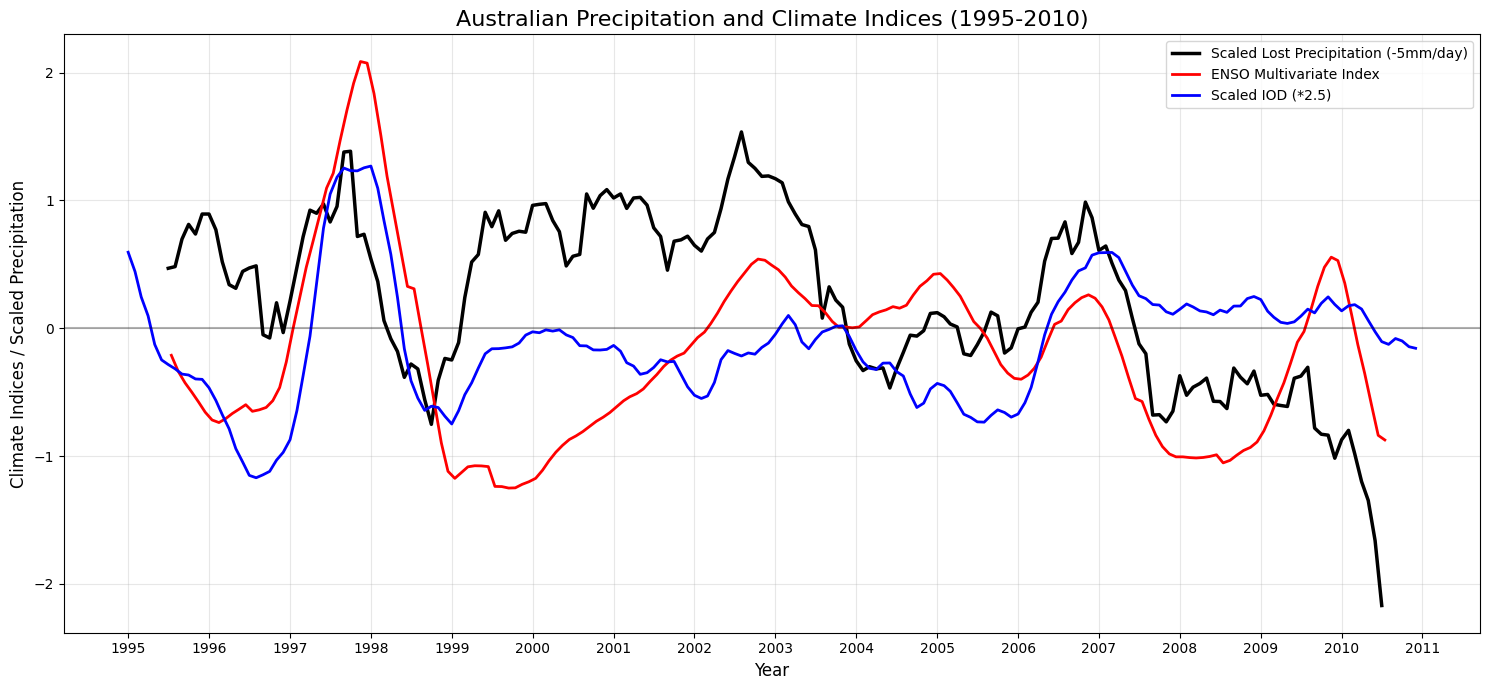

In [47]:
# Plot all climate indices on the same scale with precipitation multiplied by 10
def plot_rescaled_climate_indices(rolling_results, mei_data, iod_data):
    """
    all necessary parameters should be loaded in from running above cells.
    """
    fig, ax = plt.subplots(figsize=(15, 7))

    precip = rolling_results['Australia Average']
    mei = mei_data['mei_12m_avg']
    iod = iod_data['iod_12m_avg']

    # Scale the anamolies and iod so that viewer can trace the connection between these phenomena
    scaled_precip = precip * -5
    scaled_iod = iod*2.5

    # Plot all series on the same scale
    ax.plot(scaled_precip.index, scaled_precip, 'k-', linewidth=2.5, label='Scaled Lost Precipitation (-5mm/day)')
    ax.plot(mei.index, mei, 'r-', linewidth=2, label='ENSO Multivariate Index')
    ax.plot(iod.index, scaled_iod, 'b-', linewidth=2, label='Scaled IOD (*2.5)')


    # Add zero line, axis, labels and title. format axis
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Climate Indices / Scaled Precipitation', fontsize=12)
    ax.set_title('Australian Precipitation and Climate Indices (1995-2010)', fontsize=16)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Add gridlines and legend
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.savefig('rescaled_climate_indices.png', dpi=300, bbox_inches='tight')
    plt.show()
    return fig, ax

# Call the plotting function, assuming all the needed datasets are available
if 'mei_data' in globals() and 'rolling_results' in globals() and 'iod_data' in globals():
    plot_rescaled_climate_indices(rolling_results, mei_data, iod_data)
else:
    print("One or more datasets are missing.")
    print("Make sure to run all the data processing cells first.")


